In [24]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg

## Genetic Algorithm Support Code

We begin by implementing a class called GASsetting that will store all the settings for the algorithm. Fields include

<ul>
<li>numParents: number of members of breeding pool
<li>numChildren: number of individuals in each generation
<li>numGenerations: number of generations
<li>selection: which selection algorithm to use 
<li>mutation: scale for std. devation of normal distribution used to randomly sample points for mutation. We pull from a normal distribution centered at the parameter value with std. deviation mutation*value
<li>eliteCount: number of individuals from previous generation that get to live into the current generation.
</ul>

In [3]:
class GASettings:
    def __init__( self, numParents = 10, numChildren = 50 ):
        self.numParents = numParents;
        self.numChildren = numChildren;
        self.numGenerations = 5;
        self.selection = 'truncation'; 
        self.crossover = 'uniform';
        self.mutation = 0.05; # std of normal distribution computed as mutation*value
        self.eliteCount = 1;

## Write select_pool

We will build the genetic algorith bottom-up. First, write the select_pool function, with the members of the previous generation and their costs as input (along with the settings). 

Select pool should return a tuple (P, Pcost)

where P is the numParents x numParameter matrix of individuals in the breeding pool and Pcost is the array of their costs.

If settings.selection is 'uniform', then each member of P is chosen randomly from G (where each invidivual in G is equally likely to be chosen).

If settings.selection is 'truncation', then each member of P is chosen randomly from settings.numParents lowest cost individuals in G (where each individual in that set is equally likely to be chosen and it is OK if the same individual is chosen more than once). We can assume that G is sorted by cost, so this means we choose from the first settings.numParents individuals.

In [1]:
def select_pool( G, Gcost, settings ):
    """ Select a breding pool from the previous generation.
    G is numChildren x numParameters
    Gcost is numChildren long and is sorted in ascending order.
    Returns (P,Pcost)
    where 
    P is numParents x numParameters
    Pcost is numParents long.
    """
    if Gcost.size != settings.numChildren:
        print("problem")
        return
    P = np.zeros( (settings.numParents,G.shape[1]) )
    Pcost = np.zeros( (settings.numParents,) )
    Pidxs = []
    if settings.selection == 'truncation':
        for i in range(settings.numParents):
            idx = np.random.choice(settings.numParents)
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    elif settings.selection == 'uniform':
        for i in range(settings.numParents):
            idx = np.random.choice(G.shape[0])
            P[i,:] = G[idx,:]
            Pcost[i] = Gcost[idx]

    else:
        print( "Unknown selection operator: ", settings.selection )
    return (P, Pcost)

## Test the selection operators

Text(0, 0.5, 'Frequency')

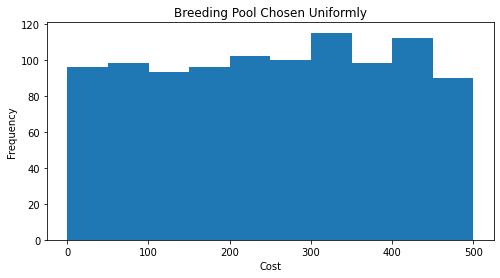

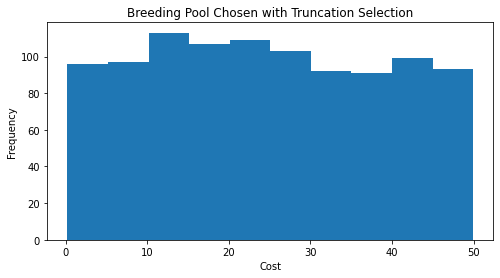

In [5]:
# Test the selection operators
# Make fake parameters, using the index as the values (so we can differentiate them)
lam = 10000 # number of individuals in generation
mu = 1000 # number of individuals in breeding pool
NP = 5 # num of parameters per individual
G = np.zeros( (lam,NP) )
for i in range(lam):
    G[i,:] = i
Gcost = np.linspace(0.1,500,lam)
settings = GASettings(numParents=mu, numChildren=lam)

settings.selection = 'uniform'
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen Uniformly")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')

settings.selection = 'truncation'
(P, Pcost) = select_pool(G, Gcost, settings)
plt.figure( figsize=(8,4) )
plt.hist( Pcost );
plt.title( "Breeding Pool Chosen with Truncation Selection")
plt.xlabel( 'Cost')
plt.ylabel('Frequency')

## Write generateIndividual

Write the code that will generate a random individual in parameter space. The individual should have entries between the lower bound and upper bound and should have finite cost. We make 1000 attempts to find a parameter set that leads to a finite code before giving up and just returning np.inf.

In [7]:
def generateIndividual(cost_fcn, lb,ub):
    '''
    Generate a viable individual (i.e one whos cost function is finite)
    and return it and its cost.
    If 1000 tries fails to yield an individual, then the paramets and an infinite cost
    are returned.
    Each individual is generated by randomly chosing each entry params[i] 
    so that lb[i] <= params[i] <= ub[i]
    '''
    params = np.zeros(lb.shape);
    cost   = np.inf;
    for i in range( 1000 ):
        params = lb + np.multiply( np.random.random(lb.size), ub-lb);
        cost   = cost_fcn(params);
        if np.isfinite(cost):
            return (params, cost);
    return (params, np.inf)

## Test generateIndividual

Run generateIndividual with the pattern cost function to generate 1000 individuals, storing each one as a row in a 1000x7 matrix. Use [0,4,1,1,2,2,0] as the lower bounds and [5,6,3,2,4,4,2] as the upper bounds.

Test it by plotting the result as 5 columns of values (i.e. x-axis is 1:7 and the y-axis is the parameter value). This isn't much of a test, but it makes sure that the points are in the expected ranges. We wil also plot the costs (individual's index on x-axis, cost on y-axis) just to see that it was computed within a range that makes sense. It should look like a busy rectangle full or asterisks.

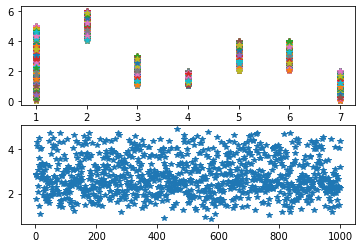

In [23]:
def pattern_cost_function( params ):
    return scipy.linalg.norm( params-np.array([1,5,2.5,2,4,3,0]) )

lam = 1000 # number of individuals in generation
mu = 100 # number of individuals in breeding pool
NP = 7 # num of parameters per individual
settings = GASettings(numParents=mu, numChildren=lam)

lb = np.array([0,4,1,1,2,2,0])
ub = np.array([5,6,3,2,4,4,2])
G = np.zeros( (lam,NP) )
for i in range(lam):
    (G[i,:], Gcost[i]) = generateIndividual(pattern_cost_function,lb,ub)
    
plt.subplot( 2, 1, 1 )
plt.plot( np.arange(1,NP+1), G.T, '*');
plt.subplot( 2, 1, 2 )
plt.plot( np.arange(1,lam+1), Gcost, '*');